In [1]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
TF_DETERMINISTIC_OPS=1

# Set random seeds for reproducibility
random.seed(25)
np.random.seed(25)
tf.random.set_seed(25)

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle-2.json ~/.kaggle/


cp: cannot stat 'kaggle-2.json': No such file or directory


In [3]:
! kaggle datasets download -d "ashfakyeafi/cat-dog-images-for-classification"

Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/cat-dog-images-for-classification
License(s): CC0-1.0
 98% 534M/545M [00:02<00:00, 247MB/s]
100% 545M/545M [00:02<00:00, 226MB/s]


In [4]:

import zipfile
zip_ref = zipfile.ZipFile('/content/cat-dog-images-for-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
df=pd.read_csv('/content/cat_dog.csv')

In [6]:
df.head()

,image,labels
0,dog.11289.jpg,1
1,cat.10836.jpg,0
2,cat.7970.jpg,0
3,cat.2212.jpg,0
4,dog.2653.jpg,1


In [9]:
import os
from sklearn.model_selection import train_test_split

df["image_path"] = df["image"].apply(lambda x: os.path.join("/content/cat_dog", x))

df = df[df["image_path"].apply(os.path.exists)]
df.head()


,image,labels,image_path
0,dog.11289.jpg,1,/content/cat_dog/dog.11289.jpg
1,cat.10836.jpg,0,/content/cat_dog/cat.10836.jpg
2,cat.7970.jpg,0,/content/cat_dog/cat.7970.jpg
3,cat.2212.jpg,0,/content/cat_dog/cat.2212.jpg
4,dog.2653.jpg,1,/content/cat_dog/dog.2653.jpg


In [11]:
# Split the data
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df["labels"], random_state=42)  # use stratify:-the split preserves the proportion of each class in the labels column.
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data["labels"], random_state=42)

In [12]:
def preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (128, 128))
    img = img / 255.0
    return img, label


In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data["image_path"].values, train_data["labels"].values))
train_dataset = train_dataset.map(preprocess_image).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_data["image_path"].values, val_data["labels"].values))
val_dataset = val_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data["image_path"].values, test_data["labels"].values))
test_dataset = test_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)



In [14]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [15]:
# Use VGG16 for transfer learning
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
# create the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Reduced learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [20]:
history=model.fit(train_dataset,validation_data=val_dataset,epochs=50,callbacks=[early_stopping,reduce_lr])

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.7943 - loss: 3.2300 - val_accuracy: 0.8752 - val_loss: 0.9333 - learning_rate: 1.0000e-04
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.8757 - loss: 0.8134 - val_accuracy: 0.8923 - val_loss: 0.5573 - learning_rate: 1.0000e-04
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 67ms/step - accuracy: 0.8869 - loss: 0.5301 - val_accuracy: 0.8825 - val_loss: 0.4455 - learning_rate: 1.0000e-04
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.8905 - loss: 0.4350 - val_accuracy: 0.8775 - val_loss: 0.4170 - learning_rate: 1.0000e-04
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 60ms/step - accuracy: 0.8909 - loss: 0.3893 - val_accuracy: 0.8935 - val_loss: 0.3648 - learning_rate: 1.0000e-04
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - accuracy: 0.8961 - loss: 0.3530 - val_accuracy: 0.8997 - val_loss: 0.3330 - learning_rate: 1.0000e-04
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/ste

In [21]:
#unbatch(): Converts the batched dataset into a dataset of individual samples.
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%, Test Loss: {test_loss:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.9032 - loss: 0.2812
Test Accuracy: 90.48%, Test Loss: 0.2704


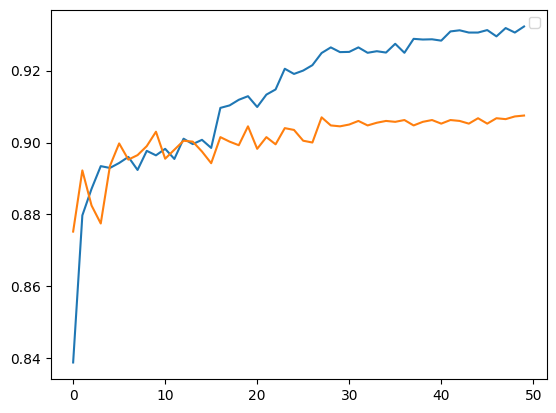

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend()
plt.show()

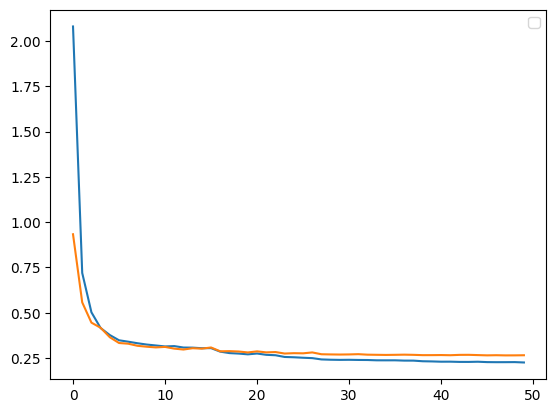

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend()
plt.show()

In [24]:
model.save_weights('model_VGG16.weights.h5')

In [25]:
model.save('cnn_model_VGG16.h5')

In [30]:
sample_dataset = test_dataset.unbatch().take(100)

# lists to store images, labels, and predictions
images, true_labels, predictions = [], [], []

for img, label in sample_dataset:
    images.append(img.numpy())
    true_labels.append(label.numpy())
    prediction = model.predict(tf.expand_dims(img, axis=0))[0][0]
    predictions.append(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

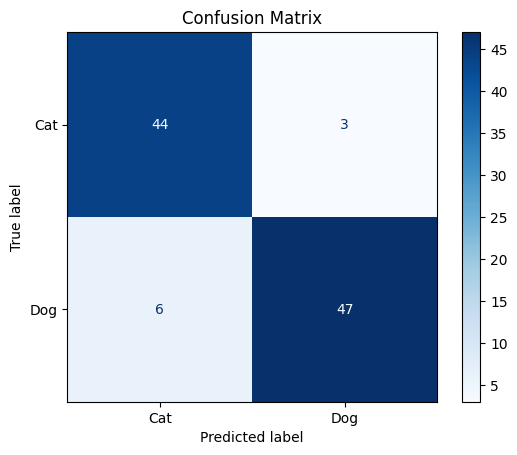

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Convert predictions to binary labels (threshold at 0.5)
binary_predictions = [1 if pred >= 0.5 else 0 for pred in predictions]

# Generate the confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [38]:
image_paths = [
    "/content/cat_img.jpg",
    "/content/dog.jpg",
    "/content/kitten.jpg",
    "/content/dog_image.jpg"

]

In [34]:
import tensorflow as tf
import matplotlib.pyplot as plt

def preprocess_single_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (128, 128))
    img = img / 255.0
    return tf.expand_dims(img, axis=0)

def predict_and_display(image_path, model):
    processed_img = preprocess_single_image(image_path)

    prediction = model.predict(processed_img)[0][0]
    predicted_label = "Dog" if prediction > 0.5 else "Cat"

    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    plt.imshow(img.numpy())
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


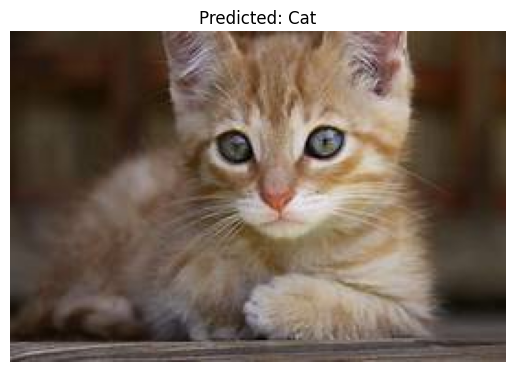

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


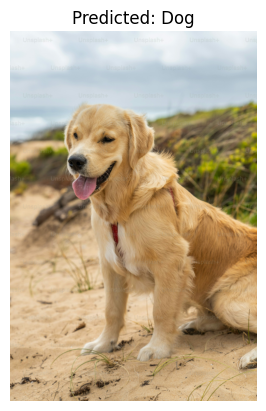

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


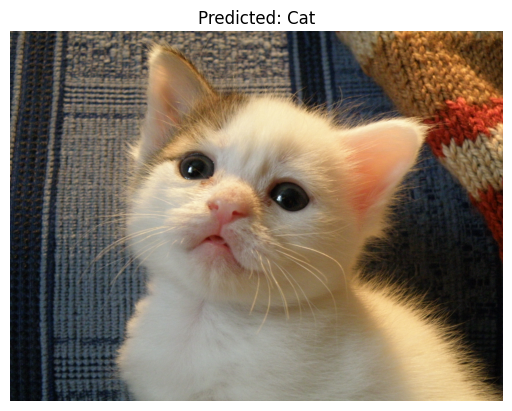

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


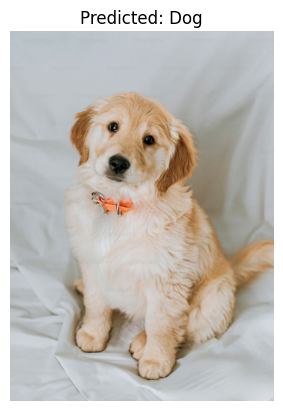

In [39]:
for img_path in image_paths:
    predict_and_display(img_path, model)